In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import geopandas as gpd
from statsmodels.api

def extractType(fl): return fl.split('_')[-1].split('.')[0]
def extractRegion(fl): return fl.split('/')[-1].split('_')[0].split('r')[-1]
def computeDatetime(df): return '%i-%i-%i'%(df.year,df.month,df.day)

In [41]:
# objective functions

def r2(x,y):
    # from: https://en.wikipedia.org/wiki/Coefficient_of_determination#As_explained_variance
    yBar = np.nanmean(y)
    SStot = np.nansum(np.square(y-yBar)) # compute sum of squares total
    SSres = np.nansum(np.square(y-x)) # residual sum of squares
    
    return 1.-(SSres/SStot)

def NSE(x,y):
    # from: https://en.wikipedia.org/wiki/Nash%E2%80%93Sutcliffe_model_efficiency_coefficient
    yBar = np.nanmean(y)
    return 1. - (np.nansum(np.square(x-y))/np.nansum(np.nanmean(y-yBar)))

def MAE(x,y):
    # from: https://en.wikipedia.org/wiki/Mean_absolute_error
    return np.nanmean(np.abs(x-y))
    
def RMSE(x,y):
    # from: https://en.wikipedia.org/wiki/Root-mean-square_deviation
    return np.sqrt(np.nanmean(np.square(x-y)))

In [54]:
def loadDF(forcingSet=None,region=None,forcingType=None):
    # collect data files
    files = pd.DataFrame()
    files['path'] = glob.glob('./data/forcing_sets/%s/*.cbh'%forcingSet)
    files['type'] = files.path.map(extractType)
    files['region'] = files.path.map(extractRegion)

    fl = files.loc[(files.type==forcingType) & (files.region == region)].path.values[0]
    dat = pd.read_csv(fl,skiprows=3,delim_whitespace=True,header=None, names = None, low_memory=True, na_values='NaN')
    
    # make column names
    n = len(dat.columns)
    header = ['year','month','day','hour','minute','second']
    for i in range(1,n+1-len(header)):
        header.append('HRU_ID_%s'%i)

    dat.columns = header
    dat['datetime'] = dat.apply(computeDatetime,axis=1)
    dat.index = pd.DatetimeIndex(dat.datetime)
    
    for var in ['year','month','day','hour','minute','second', 'datetime']: del dat[var]
        
    return dat

In [55]:
region = '10U'
forcingType = 'tmin'
daymet = loadDF(forcingSet='daymet',region=region,forcingType=forcingType)
maurer = loadDF(forcingSet='maurer',region=region,forcingType=forcingType)
idaho = loadDF(forcingSet='idaho',region=region,forcingType=forcingType)

In [67]:
# crop to common time periods
starts = []
ends = []
datasets = [daymet,maurer,idaho]
for ds in datasets:
    starts.append(ds.index.min())
    ends.append(ds.index.max())
    
strt = np.max(starts)
nd = np.min(ends)

daymet = daymet[strt:nd]
maurer = maurer[strt:nd]
idaho = idaho[strt:nd]

In [69]:
daymet.shape

(11323, 10299)

In [70]:
maurer.shape

(11323, 10299)

In [71]:
idaho.shape

(11323, 10299)

In [72]:
r2res = []
MAEres = []
RMSEres = []
NSEres = []

for hru in daymet.columns:
    x = daymet[hru].values
    y = maurer[hru].values
    
    r2res.append(r2(x,y))
    MAEres.append(MAE(x,y))
    RMSEres.append(RMSE(x,y))
    NSEres.append(NSE(x,y))

/home/tbarnhart/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


In [77]:
results = pd.DataFrame()
results['HRU'] = np.arange(1,len(daymet.columns)+1)
results['r2'] = r2res
results['MAE'] = MAEres
results['RMSE'] = RMSEres
results['NSE'] = NSEres

del r2res
del MAEres
del RMSEres
del NSEres
del daymet
del maurer

In [85]:
results.describe()

,HRU,r2,MAE,RMSE,NSE
count,10299.000000,10299.000000,10299.000000,10299.000000,1.029900e+04
mean,5150.000000,0.964845,2.029417,2.686753,-inf
std,2973.209545,0.071073,1.467442,1.754107,NaN
min,1.000000,0.110818,0.630140,0.907754,-inf
25%,2575.500000,0.974853,1.220963,1.683907,-3.444666e+19
50%,5150.000000,0.988121,1.545642,2.118375,-4.176907e+18
75%,7724.500000,0.992914,2.132468,2.874556,3.140466e+19
max,10299.000000,0.998132,12.701300,14.782622,8.765936e+22


In [86]:
shp = gpd.read_file('./data/nhrus/clean_AEA/nhru_10U_clean.shp')

In [93]:
shp['metric'] = results['MAE']

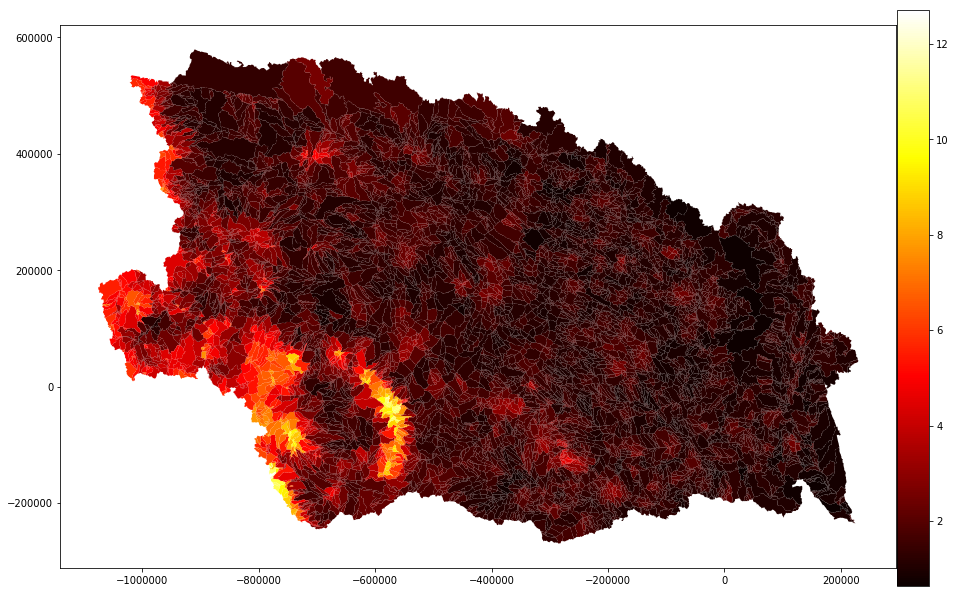

In [94]:
vmin = shp.metric.min()
vmax = shp.metric.max()

ax = shp.plot(column = 'metric', figsize=(15,10), vmin=vmin,vmax=vmax, cmap='hot')

fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm,cax=cax)
# colorbar with geopandas comes from here: https://stackoverflow.com/questions/36008648/colorbar-on-geopandas

In [84]:
regions = pd.DataFrame()
regions['path'] = glob.glob('./data/nhrus/clean_AEA/*.shp')
regions

In [83]:
regions

['./data/nhrus/clean_AEA/nhru_09_clean.shp',
 './data/nhrus/clean_AEA/nhru_10L_clean.shp',
 './data/nhrus/clean_AEA/nhru_16_clean.shp',
 './data/nhrus/clean_AEA/nhru_17_clean.shp',
 './data/nhrus/clean_AEA/nhru_07_clean.shp',
 './data/nhrus/clean_AEA/nhru_21_clean.shp',
 './data/nhrus/clean_AEA/nhru_04_clean.shp',
 './data/nhrus/clean_AEA/nhru_12_clean.shp',
 './data/nhrus/clean_AEA/nhru_03_clean.shp',
 './data/nhrus/clean_AEA/nhru_14_clean.shp',
 './data/nhrus/clean_AEA/nhru_01_clean.shp',
 './data/nhrus/clean_AEA/nhru_13_clean.shp',
 './data/nhrus/clean_AEA/nhru_08_clean.shp',
 './data/nhrus/clean_AEA/nhru_15_clean.shp',
 './data/nhrus/clean_AEA/nhru_05_clean.shp',
 './data/nhrus/clean_AEA/nhru_18_clean.shp',
 './data/nhrus/clean_AEA/nhru_20_clean.shp',
 './data/nhrus/clean_AEA/nhru_02_clean.shp',
 './data/nhrus/clean_AEA/nhru_11_clean.shp',
 './data/nhrus/clean_AEA/nhru_06_clean.shp',
 './data/nhrus/clean_AEA/nhru_10U_clean.shp']

In [35]:
hru

'datetime'

In [34]:
maurer.dtypes

HRU_ID_1        float64
HRU_ID_2        float64
HRU_ID_3        float64
HRU_ID_4        float64
HRU_ID_5        float64
HRU_ID_6        float64
HRU_ID_7        float64
HRU_ID_8        float64
HRU_ID_9        float64
HRU_ID_10       float64
HRU_ID_11       float64
HRU_ID_12       float64
HRU_ID_13       float64
HRU_ID_14       float64
HRU_ID_15       float64
HRU_ID_16       float64
HRU_ID_17       float64
HRU_ID_18       float64
HRU_ID_19       float64
HRU_ID_20       float64
HRU_ID_21       float64
HRU_ID_22       float64
HRU_ID_23       float64
HRU_ID_24       float64
HRU_ID_25       float64
HRU_ID_26       float64
HRU_ID_27       float64
HRU_ID_28       float64
HRU_ID_29       float64
HRU_ID_30       float64
                 ...   
HRU_ID_10271    float64
HRU_ID_10272    float64
HRU_ID_10273    float64
HRU_ID_10274    float64
HRU_ID_10275    float64
HRU_ID_10276    float64
HRU_ID_10277    float64
HRU_ID_10278    float64
HRU_ID_10279    float64
HRU_ID_10280    float64
HRU_ID_10281    